In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple CNN for velocity field prediction
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 2, kernel_size=3, padding=1)  # Output velocity field with 2 channels
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)  # Output 2-channel velocity field
        return x


In [2]:
# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
# Import previously defined loss functions
# MSELoss, GL2Loss, and TotalLoss
from loss import MSELoss, GL2Loss, TotalLoss
# Instantiate the total loss function with GL2 regularization
lambda_gl2 = 0.1  # You can adjust this parameter
loss_fn = TotalLoss(lambda_gl2=lambda_gl2, epsilon=1.0).to(device)


In [4]:
# Generate synthetic velocity field and wave function data
def generate_synthetic_data(batch_size, grid_size,device):
    """
    Generate synthetic velocity field (u_x, u_y) and wave function (Re(psi), Im(psi)).
    """
    # Random velocity field (u_x, u_y)
    velocity_field = torch.randn(batch_size, 2, grid_size, grid_size, device=device)  # 2 channels: u_x, u_y
    
    # Random wave function (Re(psi), Im(psi))
    real_psi = torch.randn(batch_size, 1, grid_size, grid_size, device=device)
    imag_psi = torch.randn(batch_size, 1, grid_size, grid_size, device=device)
    psi = torch.cat([real_psi, imag_psi], dim=1)  # Concatenate real and imaginary parts into 2 channels
    
    return velocity_field, psi

# Example usage to create data
batch_size = 10
grid_size = 64
u_true, psi_true = generate_synthetic_data(batch_size, grid_size,device)


In [5]:
u_true.shape, psi_true.shape

(torch.Size([10, 2, 64, 64]), torch.Size([10, 2, 64, 64]))

In [9]:
# Instantiate the model
model = SimpleCNN().to(device)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 2000
for epoch in range(num_epochs):
    # Forward pass
    u_pred = model(psi_true)  # Use wave function as input to predict velocity field
    
    # Compute loss
    loss = loss_fn(u_pred, u_true, psi_true)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/2000], Loss: 4.4841
Epoch [2/2000], Loss: 4.4726
Epoch [3/2000], Loss: 4.4634
Epoch [4/2000], Loss: 4.4519
Epoch [5/2000], Loss: 4.4387
Epoch [6/2000], Loss: 4.4251
Epoch [7/2000], Loss: 4.4113
Epoch [8/2000], Loss: 4.3982
Epoch [9/2000], Loss: 4.3899
Epoch [10/2000], Loss: 4.3868
Epoch [11/2000], Loss: 4.3907
Epoch [12/2000], Loss: 4.3931
Epoch [13/2000], Loss: 4.3929
Epoch [14/2000], Loss: 4.3878
Epoch [15/2000], Loss: 4.3858
Epoch [16/2000], Loss: 4.3811
Epoch [17/2000], Loss: 4.3806
Epoch [18/2000], Loss: 4.3784
Epoch [19/2000], Loss: 4.3794
Epoch [20/2000], Loss: 4.3787
Epoch [21/2000], Loss: 4.3792
Epoch [22/2000], Loss: 4.3788
Epoch [23/2000], Loss: 4.3780
Epoch [24/2000], Loss: 4.3772
Epoch [25/2000], Loss: 4.3760
Epoch [26/2000], Loss: 4.3748
Epoch [27/2000], Loss: 4.3741
Epoch [28/2000], Loss: 4.3729
Epoch [29/2000], Loss: 4.3728
Epoch [30/2000], Loss: 4.3721
Epoch [31/2000], Loss: 4.3718
Epoch [32/2000], Loss: 4.3712
Epoch [33/2000], Loss: 4.3705
Epoch [34/2000], Lo

In [10]:
# Generate test data
u_test, psi_test = generate_synthetic_data(batch_size, grid_size, device)

# Forward pass through the trained model
u_test_pred = model(psi_test)

# Calculate loss on test data
test_loss = loss_fn(u_test_pred, u_test, psi_test)
print(f'Test Loss: {test_loss.item():.4f}')


Test Loss: 4.8612


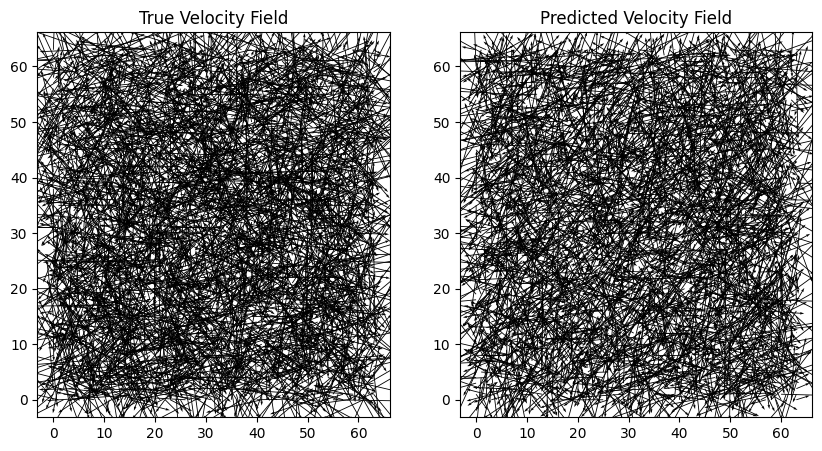

In [11]:
import matplotlib.pyplot as plt

# Visualize a single example from the test set
index = 0
u_true_example = u_test[index].detach().cpu().numpy()
u_pred_example = u_test_pred[index].detach().cpu().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.quiver(u_true_example[0], u_true_example[1], scale=10)
plt.title("True Velocity Field")
plt.subplot(1, 2, 2)
plt.quiver(u_pred_example[0], u_pred_example[1], scale=10)
plt.title("Predicted Velocity Field")
plt.show()
